# Phase 1 - Week 4 - Day 1 PM - Artificial Neural Network

> **NOTES**

> Before you run the notebook below, **it is recommended to run the program using the GPU** so that the training process doesn't take too long.
> If you use Google Colab, then you can set it by following the steps: `Runtime` >> `Change runtime type` >> `T4 GPU`.

# A. Binary Classification

## A.1 - Import Libraries & Data Loading

In the first tutorial, we will implement Binary Classification using Titanic dataset to build neural network models.

The purpose of this notebook is to demonstrate the creation of an ANN model in a general sense, so some details such as EDA, handling outliers, checking types of missing values, etc., are omitted.

In reality, you should consider these aspects for the project you are working on so that your ANN model is an optimal model.

In [1]:
# Import Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report

In [2]:
# Load the Titanic dataset

url = 'https://raw.githubusercontent.com/FTDS-learning-materials/phase-1/master/w1/P1W1D3AM%20-%20Feature%20Engineering%20-%20Part%201%20-%20Titanic.csv'
data = pd.read_csv(url)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## A.2 - Feature Engineering

### A.2.1 - Data Splitting

In [3]:
# Splitting between `X` and `y`

X = data.drop('Survived', axis=1)
y = data['Survived']

In [4]:
# Splitting between Train-Set, Val-Set, and Test-Set

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (643, 11)
Val Size   :  (114, 11)
Test Size  :  (134, 11)


### A.2.2 - Handling Missing Values

In [5]:
# Check Missing Values on X_train

X_train.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            131
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          497
Embarked         2
dtype: int64

In [6]:
# Check Missing Values on X_val

X_val.isnull().sum()

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            22
SibSp           0
Parch           0
Ticket          0
Fare            0
Cabin          94
Embarked        0
dtype: int64

In [7]:
# Check Missing Values on X_test

X_test.isnull().sum()

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            24
SibSp           0
Parch           0
Ticket          0
Fare            0
Cabin          96
Embarked        0
dtype: int64

We will impute this missing values in Pipeline using median imputation.

### A.2.3 - Feature Selection

Let's assume columns `PassengerId`, `Cabin`, `Ticket`, `Embarked`, and `Name` do not have strong correlations against the target (column `Survived`).

In [8]:
# Drop Columns

X_train.drop(['PassengerId', 'Cabin', 'Ticket', 'Embarked', 'Name'], axis=1, inplace=True)
X_val.drop(['PassengerId', 'Cabin', 'Ticket', 'Embarked', 'Name'], axis=1, inplace=True)
X_test.drop(['PassengerId', 'Cabin', 'Ticket', 'Embarked', 'Name'], axis=1, inplace=True)

X_train

,Pclass,Sex,Age,SibSp,Parch,Fare
868,3,male,NaN,0,0,9.5000
223,3,male,NaN,0,0,7.8958
846,3,male,NaN,8,2,69.5500
171,3,male,4.0,4,1,29.1250
435,1,female,14.0,1,2,120.0000
...,...,...,...,...,...,...
533,3,female,NaN,0,2,22.3583
302,3,male,19.0,0,0,0.0000
473,2,female,23.0,0,0,13.7917
283,3,male,19.0,0,0,8.0500


### A.2.4 - Pipeline

In [9]:
# Get Numerical Columns and Categorical Columns

num_columns = X_train.select_dtypes(include=np.number).columns.tolist()
cat_columns = X_train.select_dtypes(include=['object']).columns.tolist()

print('Numerical Columns : ', num_columns)
print('Categorical Columns : ', cat_columns)

Numerical Columns :  ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical Columns :  ['Sex']


In [10]:
# Create A Pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy='median'),
                             StandardScaler())

cat_pipeline = make_pipeline(OneHotEncoder())

final_pipeline = ColumnTransformer([
    ('pipe_num', num_pipeline, num_columns),
    ('pipe_cat', cat_pipeline, cat_columns)
])

In [11]:
# Fit and Transform

X_train = final_pipeline.fit_transform(X_train)
X_val = final_pipeline.transform(X_val)
X_test = final_pipeline.transform(X_test)
X_train.shape

(643, 7)

## A.3 - Sequential API

### A.3.1 - Model Definition

In [12]:
# Clear Session

import tensorflow as tf

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [13]:
# Create Sequential API

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model_sequential = Sequential()
model_sequential.add(Dense(16,
                           activation='relu',
                           kernel_initializer=tf.keras.initializers.HeNormal(seed),
                           input_shape=(7,))) # Hidden Layer 1
model_sequential.add(Dense(8,
                           activation='relu',
                           kernel_initializer=tf.keras.initializers.HeNormal(seed))) # Hidden Layer 2
model_sequential.add(Dense(1,
                           activation='sigmoid',
                           kernel_initializer=tf.keras.initializers.GlorotNormal(seed))) # Output Layer

# Compile
model_sequential.compile(loss='binary_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy'])
model_sequential.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                128       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________


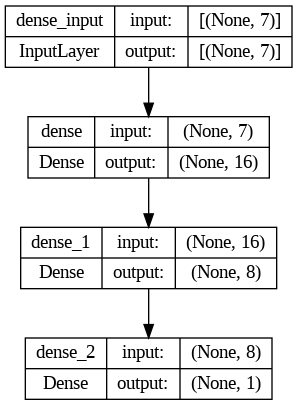

In [14]:
# Plot Layers

tf.keras.utils.plot_model(model_sequential, show_shapes=True)

### A.3.2 - Model Training

In [15]:
# Train the Model

%%time
history_seq = model_sequential.fit(X_train,
                                   y_train,
                                   epochs=20,
                                   validation_data=(X_val, y_val),
                                   batch_size=10)

Epoch 1/20
65/65 [==============================] - 12s 14ms/step - loss: 0.8321 - accuracy: 0.4541 - val_loss: 0.7100 - val_accuracy: 0.4561
Epoch 2/20
65/65 [==============================] - 1s 9ms/step - loss: 0.6695 - accuracy: 0.5925 - val_loss: 0.6356 - val_accuracy: 0.5877
Epoch 3/20
65/65 [==============================] - 1s 9ms/step - loss: 0.6027 - accuracy: 0.6656 - val_loss: 0.5930 - val_accuracy: 0.6491
Epoch 4/20
65/65 [==============================] - 1s 8ms/step - loss: 0.5610 - accuracy: 0.7201 - val_loss: 0.5565 - val_accuracy: 0.6754
Epoch 5/20
65/65 [==============================] - 1s 8ms/step - loss: 0.5287 - accuracy: 0.7543 - val_loss: 0.5222 - val_accuracy: 0.7807
Epoch 6/20
65/65 [==============================] - 1s 9ms/step - loss: 0.5023 - accuracy: 0.7807 - val_loss: 0.4905 - val_accuracy: 0.7982
Epoch 7/20
65/65 [==============================] - 1s 8ms/step - loss: 0.4815 - accuracy: 0.7963 - val_loss: 0.4674 - val_accuracy: 0.8070
Epoch 8/20
65/65 [

### A.3.3 - Model Evaluation

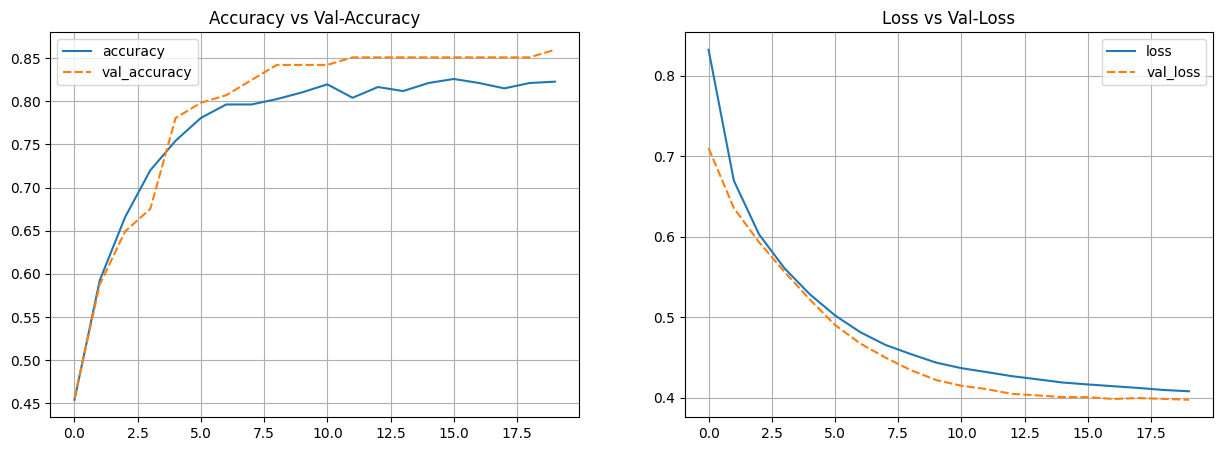

In [16]:
# Plot Training Results

history_seq_df = pd.DataFrame(history_seq.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_seq_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_seq_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

From the plot above, it can be seen that the model experienced good-fit, indicated by both loss decreasing and the gap is small.

In [17]:
# Model Evaluation of test-set

y_pred_seq = model_sequential.predict(X_test)
y_pred_seq = np.where(y_pred_seq >= 0.5, 1, 0)

print(classification_report(y_test, y_pred_seq))

5/5 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        78
           1       0.80      0.71      0.75        56

    accuracy                           0.81       134
   macro avg       0.80      0.79      0.80       134
weighted avg       0.81      0.81      0.80       134



## A.4 - Functional API

### A.4.1 - Model Definition

In [18]:
# Clear Session

import tensorflow as tf

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [19]:
# Create Functional Model

from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras import Model

input_layer = Input(shape=(7,))
hidden_layer_1 = Dense(16, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed))(input_layer)
hidden_layer_2 = Dense(8, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed))(hidden_layer_1)

concat_layer = concatenate([input_layer, hidden_layer_2])
output_layer = Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotNormal(seed))(concat_layer)

model_functional = Model(inputs=input_layer, outputs=output_layer)

# Compile
model_functional.compile(loss='binary_crossentropy',
                         optimizer='adam',
                         metrics='accuracy')
model_functional.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 16)           128         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 8)            136         ['dense[0][0]']                  
                                                                                                  
 concatenate (Concatenate)      (None, 15)           0           ['input_1[0][0]',                
                                                                  'dense_1[0][0]']            

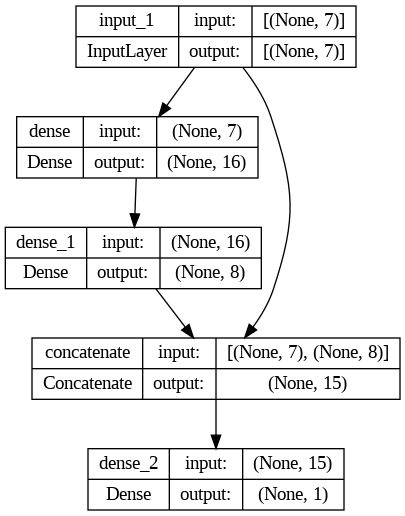

In [20]:
# Plot Layers

tf.keras.utils.plot_model(model_functional, show_shapes=True)

### A.4.2 - Model Training

In [21]:
# Train the Model

%%time
history_func = model_functional.fit(X_train,
                                    y_train,
                                    epochs=20,
                                    validation_data=(X_val, y_val),
                                    batch_size=10)

Epoch 1/20
65/65 [==============================] - 2s 7ms/step - loss: 0.7717 - accuracy: 0.4137 - val_loss: 0.6628 - val_accuracy: 0.5965
Epoch 2/20
65/65 [==============================] - 0s 4ms/step - loss: 0.6520 - accuracy: 0.6128 - val_loss: 0.6049 - val_accuracy: 0.7982
Epoch 3/20
65/65 [==============================] - 0s 5ms/step - loss: 0.5999 - accuracy: 0.7605 - val_loss: 0.5626 - val_accuracy: 0.8158
Epoch 4/20
65/65 [==============================] - 0s 5ms/step - loss: 0.5540 - accuracy: 0.7838 - val_loss: 0.5034 - val_accuracy: 0.8070
Epoch 5/20
65/65 [==============================] - 0s 4ms/step - loss: 0.5027 - accuracy: 0.7932 - val_loss: 0.4579 - val_accuracy: 0.8158
Epoch 6/20
65/65 [==============================] - 0s 4ms/step - loss: 0.4722 - accuracy: 0.8118 - val_loss: 0.4303 - val_accuracy: 0.8509
Epoch 7/20
65/65 [==============================] - 0s 4ms/step - loss: 0.4531 - accuracy: 0.8072 - val_loss: 0.4120 - val_accuracy: 0.8509
Epoch 8/20
65/65 [==

### A.4.3 - Model Evaluation

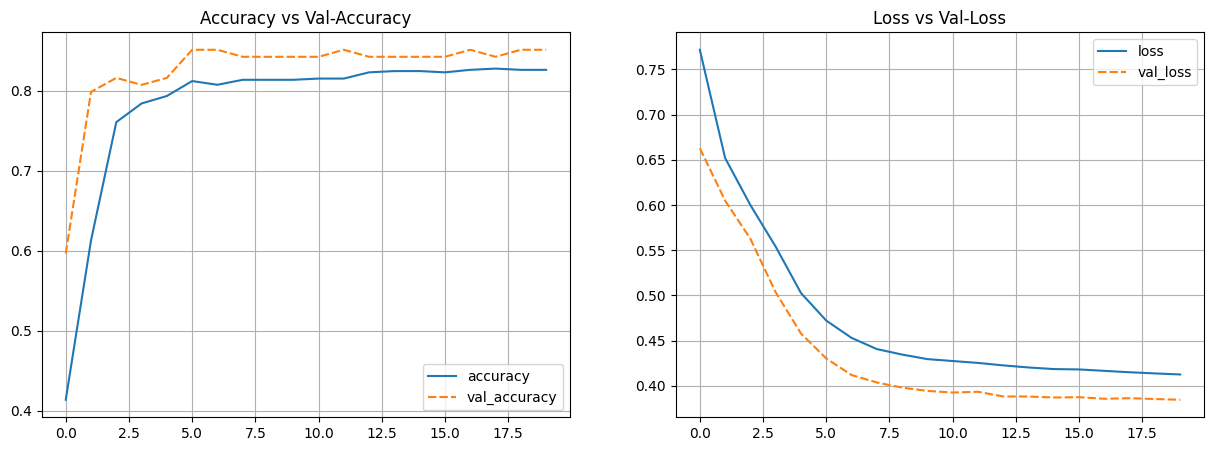

In [22]:
# Plot Training Results

history_func_df = pd.DataFrame(history_func.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_func_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_func_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

Luckily, our functional-model is also considered as good-fit model.

In [23]:
# Evaluate Test-Set

y_pred_func = model_functional.predict(X_test)
y_pred_func = np.where(y_pred_func >= 0.5, 1, 0)

print(classification_report(y_test, y_pred_func))

5/5 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        78
           1       0.83      0.70      0.76        56

    accuracy                           0.81       134
   macro avg       0.82      0.80      0.80       134
weighted avg       0.82      0.81      0.81       134



## A.5 - Model Saving

In [24]:
# Save Pipeline

import pickle

with open('final_pipeline.pkl', 'wb') as file_1:
  pickle.dump(final_pipeline, file_1)

In [25]:
# Model Summary

model_sequential.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                128       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Freeze Model

model_sequential.trainable = False
model_sequential.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                128       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 273
Trainable params: 0
Non-trainable params: 273
_________________________________________________________________


In [27]:
# Save ANN Model

model_sequential.save('titanic_model.h5')

# B. Multiclass Classification

## B.1 - Data Loading

To demonstrate building ANN model in Multiclass Classificaiton, we will tackle Fashion MNIST.

Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

*Source : [url](https://github.com/zalandoresearch/fashion-mnist)*

<img src='https://www.researchgate.net/profile/Saeed-Reza-Kheradpisheh/publication/342801790/figure/fig2/AS:911232181735425@1594266090934/Sample-images-from-Fashion-MNIST-dataset.png'>

In [28]:
# Data Loading

## Download the dataset
fashion_mnist = tf.keras.datasets.fashion_mnist

# Data splitting
(X_train_val, y_train_val), (X_test, y_test) = fashion_mnist.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
Train Size :  (51000, 28, 28)
Val Size   :  (9000, 28, 28)
Test Size  :  (10000, 28, 28)


In [29]:
# Define the Class Names

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [30]:
# Function for Visualize A Group of Images

def plot_digits(instances, n_data, images_per_row=10):
  n_rows = int(np.ceil(n_data/images_per_row))
  n_cols = images_per_row
  plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
  for row in range(n_rows):
      for col in range(n_cols):
          index = n_cols * row + col
          plt.subplot(n_rows, n_cols, index + 1)
          plt.imshow(instances[index], cmap='gray', interpolation='nearest')
          plt.axis('off')
          plt.title(class_names[y_train[index]], fontsize=12)
          if index == n_data-1:
            break
  plt.subplots_adjust(wspace=0.2, hspace=0.5)
  plt.show()

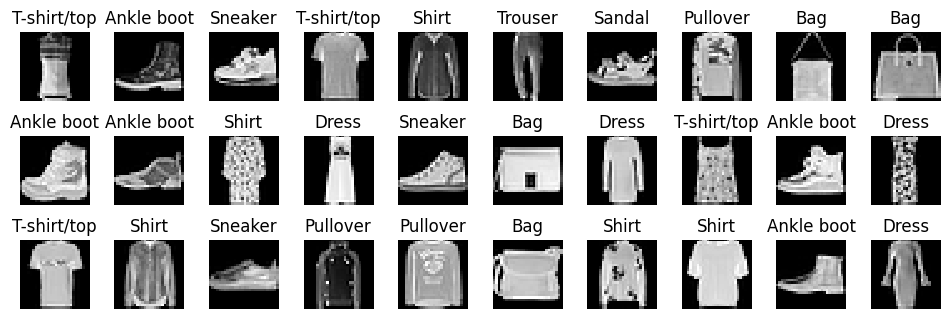

In [31]:
# Visualization of the First 50 Images

plot_digits(X_train, 30, images_per_row=10)

## B.2 - Feature Engineering

In [32]:
# Feature Scaling

X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.

## B.3 - Sequential API

### B.3.1 - Model Definition

Notes of hyperparameter `loss` :
* Use `sparse_categorical_crossentropy` :
  + The target just a class index/number such as from `0` to `9` like in this case

* Use `categorical_crossentropy` :
  + The target is in form of one-hot vectors
  + To represent class `3` the target will be `[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]`

In [33]:
# Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Create Sequential API
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

model_sequential_mnist = Sequential()
model_sequential_mnist.add(Flatten(input_shape=[28, 28]))
model_sequential_mnist.add(Dense(300, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_sequential_mnist.add(Dense(100, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_sequential_mnist.add(Dense(10, activation='softmax', kernel_initializer=tf.keras.initializers.GlorotNormal(seed)))

# Compile
model_sequential_mnist.compile(loss='sparse_categorical_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy'])
model_sequential_mnist.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


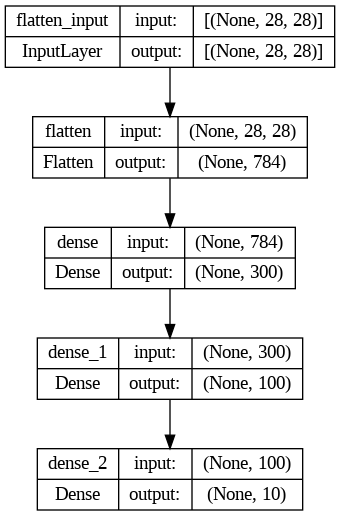

In [34]:
# Plot Layers

tf.keras.utils.plot_model(model_sequential_mnist, show_shapes=True)

### B.3.2 - Model Training

In [35]:
# Train the Model

%%time
history_seq_mnist = model_sequential_mnist.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
1594/1594 [==============================] - 9s 4ms/step - loss: 0.4841 - accuracy: 0.8255 - val_loss: 0.3782 - val_accuracy: 0.8653
Epoch 2/30
1594/1594 [==============================] - 6s 4ms/step - loss: 0.3607 - accuracy: 0.8675 - val_loss: 0.3383 - val_accuracy: 0.8781
Epoch 3/30
1594/1594 [==============================] - 6s 4ms/step - loss: 0.3255 - accuracy: 0.8795 - val_loss: 0.3465 - val_accuracy: 0.8732
Epoch 4/30
1594/1594 [==============================] - 6s 3ms/step - loss: 0.3015 - accuracy: 0.8875 - val_loss: 0.3404 - val_accuracy: 0.8759
Epoch 5/30
1594/1594 [==============================] - 6s 4ms/step - loss: 0.2838 - accuracy: 0.8929 - val_loss: 0.3706 - val_accuracy: 0.8656
Epoch 6/30
1594/1594 [==============================] - 6s 4ms/step - loss: 0.2690 - accuracy: 0.8991 - val_loss: 0.3333 - val_accuracy: 0.8810
Epoch 7/30
1594/1594 [==============================] - 6s 4ms/step - loss: 0.2550 - accuracy: 0.9045 - val_loss: 0.3272 - val_accuracy:

### B.3.3 - Model Evaluation

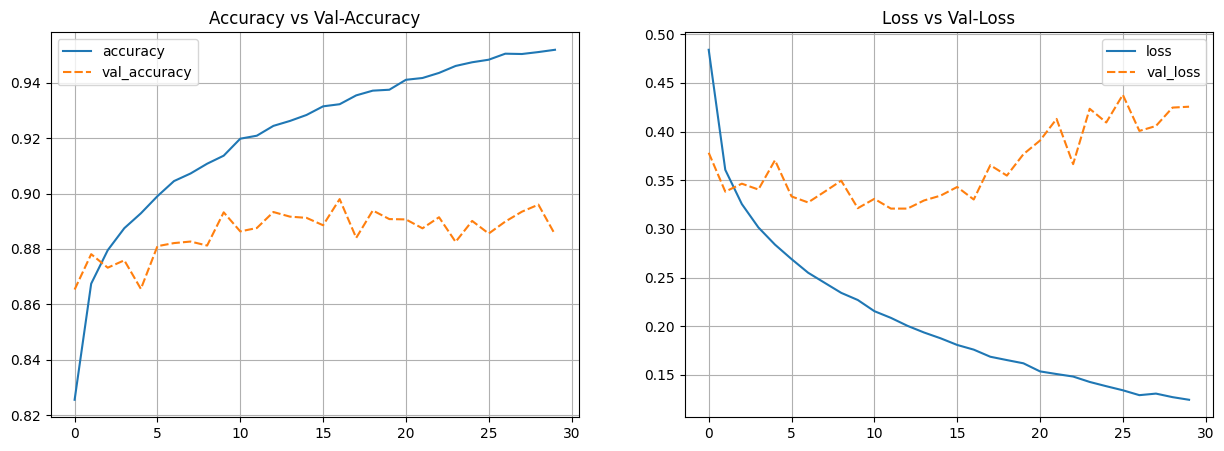

In [36]:
# Plot Training Results

history_seq_mnist_df = pd.DataFrame(history_seq_mnist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_seq_mnist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_seq_mnist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

We can see our model is overfit based on train-set and val-set. The train-loss continues to decreases as the epoch increases and val-loss decreases to a point and begins increasing again.

In [37]:
# Evaluate test-set

result = model_sequential_mnist.evaluate(X_test, y_test)
result

313/313 [==============================] - 1s 2ms/step - loss: 0.4787 - accuracy: 0.8845


[0.4787055253982544, 0.8845000267028809]

In [38]:
# Check the performance of test-set

## Get the probability
y_pred_mnist_proba = model_sequential_mnist.predict(X_test)

## Get class with maximum probability
y_pred_mnist = np.argmax(y_pred_mnist_proba, axis=-1)

## Display Classification Report
print(classification_report(y_test, y_pred_mnist, target_names=np.array(class_names)))

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.85      0.78      0.82      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.77      0.84      0.80      1000
       Dress       0.93      0.84      0.88      1000
        Coat       0.80      0.83      0.81      1000
      Sandal       0.96      0.99      0.97      1000
       Shirt       0.68      0.72      0.70      1000
     Sneaker       0.96      0.94      0.95      1000
         Bag       0.98      0.97      0.97      1000
  Ankle boot       0.96      0.96      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.89     10000
weighted avg       0.89      0.88      0.89     10000



**CONCLUSION**

Our model is considered as overfit due to increasing loss on val-set. Also, from Classification Report, it can be seen that the model has difficulty in predicting `Shirt` category.